# Sentiment Analysis on Tweets for Stocks

In [53]:
# Libraries
import twint
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import plotly.express as px

# Gathering Tweets

## Function for Twint

In [48]:
def getTweets(search_term, date, limit):
    """
    Configures Twint and returns a dataframe of the results.
    """
    # Configuring Twint for search
    c = twint.Config()

    # The limit of tweets to retrieve
    c.Limit = limit

    # Count of the number of tweets fetched
    c.Count = True

    # Search term
    c.Search = search_term

    # Removing retweets
    c.Filter_retweets = True

    # Getting popular tweets
    c.Popular_tweets = True

    # Lowercasing tweets
    c.Lowercase = True

    # English only
    c.Lang ='en'

    # Excluding tweets with links
    c.Links ='exclude'

    # Tweets until a specified date
    c.Until = date

    # Making the results pandas friendly
    c.Pandas = True
    
    # Stopping print in terminal
    c.Hide_output = True

    # Searching
    twint.run.Search(c)

    # Assigning the DF
    df = twint.storage.panda.Tweets_df
    
    # Returning nothing if there is no more tweets to scrape
    if len(df)<=0:
        return
    
    # Formatting the date
    df['date'] = df['date'].apply(lambda x: x.split(" ")[0])
    
    # Filtering out other cashtag mentions
    df = df[df['cashtags'].apply(lambda x: len(x)==1)]
    
    return df

## Using Twint
Tweet retrieval over a period of time.

In [49]:
def tweetByDay(start, stop, df):
    """
    Gathers a set amount of tweets daily between two dates and returns a dataframe.
    """
    # Finishing the recursive loop
    if start==stop:
        return df
    
    # Appending the new set of tweets for the day
    df = df.append(getTweets("$BBIG", start, 20), ignore_index=True)
    
    # The new start date
    new_start = (datetime.strptime(start, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d")
    
    print(new_start)
    
    return tweetByDay(new_start, stop, df)

In [50]:
# Getting tweets daily
df = tweetByDay("2021-09-01", "2021-08-21", pd.DataFrame())

[+] Finished: Successfully collected 20 Tweets.
2021-08-31
[+] Finished: Successfully collected 20 Tweets.
2021-08-30
[+] Finished: Successfully collected 20 Tweets.
2021-08-29
[+] Finished: Successfully collected 20 Tweets.
2021-08-28
[+] Finished: Successfully collected 20 Tweets.
2021-08-27
[+] Finished: Successfully collected 20 Tweets.
2021-08-26
[+] Finished: Successfully collected 20 Tweets.
2021-08-25
[+] Finished: Successfully collected 38 Tweets.
2021-08-24
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets.
2021-08-23
[+] Finished: Successfully collected 20 Tweets.
2021-08-22
[+] Finished: Successfully collected 20 Tweets.
2021-08-21


# Sentiment Analysis

In [59]:
# Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Getting the sentiment score
df['sentiment_score'] = df['tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])

sent_df = df.groupby('date')['sentiment_score'].mean().reset_index()

## Visualization

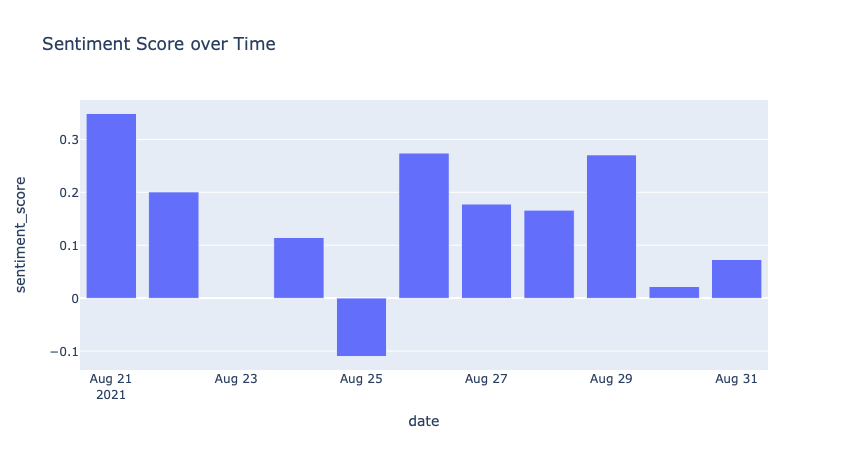

In [62]:
fig = px.bar(sent_df,
             x=sent_df['date'],
             y=sent_df['sentiment_score'],
             title="Sentiment Score over Time")

fig.show()